In [30]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [31]:
import os
import sys
import re
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

sys.path.append(
    os.path.abspath(
        os.path.expanduser(
            '~/CNN-MARL_closure_model_discovery')))


from xlb_flows.utils import vorticity_2d, energy_spectrum_2d

In [32]:
#plotting utils 
# Custom sorting key
def custom_sort_key(folder):
    match = re.search(r'N(\d+)_', folder)
    if match:
        N = int(match.group(1))
        return (0 if N < 2048 else 1, N)
    return (1, 0)

# Custom sorting key names
def custom_sort_key_names(folder):
    match = re.search(r'(\d+)_', folder)
    if match:
        N = int(match.group(1))
        return (0 if N < 2048 else 1, N)
    return (1, 0)

# get all filenames in directory
def get_names(path):
    files = os.listdir(path)
    return np.sort(files)


def plot_correlations(corrs, names, N, M):
    t = np.linspace(0, 227, M)
    idex = np.argmin(np.abs(t - 26))
    their_t = t/16
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    for i in range(N-1):
        plt.plot(t, corrs[:,i], label=names[i])
    plt.plot(t, corrs[:,N-1], 'k--', label=names[N-1])
    plt.xlabel(r'non-dimensional time $T = (U/L)t$')
    plt.ylabel(r'vorticity correlation with DNS')
    plt.legend(loc='best')
    plt.show()


def plot_spectra(spec_mean, spec_std, k, names, N):
    # plot the averaged spectrum
    plt.figure(figsize=(10,6), dpi=300)
    plt.set_cmap('cool')
    for i in range(N-1):
        plt.loglog(spec_mean[i,...]*k**5, label=names[i])
        plt.fill_between(k,
                         spec_mean[i,...]*k**5 - spec_std[i,...]*k**5,
                         spec_mean[i,...]*k**5 + spec_std[i,...]*k**5,
                         alpha=0.3
                         )
    plt.loglog(spec_mean[-1,...]*k**5,
               'k--',
               label=names[-1]
               )
    plt.fill_between(k,
                     (k**5)*(spec_mean[-1,...]-spec_std[-1,...]),
                     (k**5)*(spec_mean[-1,...] + spec_std[-1,...]), 
                     alpha=0.3,
                     color='k'
                     )
    plt.ylabel(r'Energy spectrum $E(k)k^5$')
    plt.xlabel(r'wavenumber $k$')
    plt.legend()
    plt.show()  

    # plot the averaged spectrum
    plt.figure(figsize=(10,6), dpi=300)
    plt.set_cmap('cool')
    for i in range(N-1):
        plt.loglog(spec_mean[i,...], label=names[i])
        plt.fill_between(k,
                         spec_mean[i,...]-spec_std[i,...],
                         spec_mean[i,...] + spec_std[i,...],
                         alpha=0.3
                         )
    plt.loglog(spec_mean[-1,...],
               'k--',
               label=names[-1]
               )
    plt.fill_between(k,
                     spec_mean[-1,...]-spec_std[-1,...],
                     spec_mean[-1,...] + spec_std[-1,...],
                     alpha=0.3,
                     color='k'
                     )
    #plt.loglog(1e2*k**(-5.), label="k^-5/3", linestyle="--")
    plt.ylabel(r'Energy spectrum $E(k)$')
    plt.xlabel(r'wavenumber $k$')
    plt.legend()
    plt.show()


def create_plots(test_directory):
    # Get all folder names within `test_directory`
    subfolders = [name for name in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, name))]
    subfolders = np.sort(subfolders)

    # Sort folders with custom key
    subfolders = sorted(subfolders, key=custom_sort_key)
    
    # Extract names={N}_{model} from each folder name
    #names = []
    #for folder in subfolders:
    #    match = re.search(r'N(\d+)_S\d+_U\d+_(\w+)', folder)
    #    if match:
    #        N = match.group(1)
    #        model = match.group(2)
    #        names.append(f"{N}_{model}")
    #
    #names = sorted(names, key=custom_sort_key_names)
    names = ["128_BGK",
             "128_glob",
             "128_interp",
             "128_loc",
             "128_KBC",
             "256_BGK",
             "2048_BGK"]

    paths = [test_directory+subfolder+"/" for subfolder in subfolders]

    #load all velocity files for all paths, and compute vorticity correlation
    images = [get_names(path) for path in paths]
    N = len(paths)
    M = len(images[0])-1
    corrs = np.zeros((M,N))
    print("computing vorticity correlations:")
    for i in tqdm(range(M)):
        #load all velocities 
        velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
        vorticities = np.array([vorticity_2d(velocities[j,...], 2.0*np.pi/128) for j in range(N)])
        corrs[i,...] = np.array([np.corrcoef(vorticities[j,...].flatten(), vorticities[-1,...].flatten())[0, 1] 
                                 for j in range(N)])
    #plot correlations
    plot_correlations(corrs, names, N, M)

    #compute enerty spectrum statistics
    L = int(128/2 - 1)
    a = 1*M//2 #1*M//2
    b = M-1
    spec = np.zeros((N, L, (b-a)))
    k = np.arange(L)
    # loop over all files in files1 between a and b and add to spec
    print("computing energy spectra:")
    for i in tqdm(range(a, b)):
        velocities = np.array([np.load(paths[j]+'/'+images[j][i]) for j in range(N)])
        for j in range(N):
            _, spec[j,:,i-a] = energy_spectrum_2d(velocities[j,...])
    spec_mean=spec.mean(axis=-1)
    spec_std=spec.std(axis=-1)

    # plot spectra
    plot_spectra(spec_mean, spec_std, k, names, N)


    # plot vorticity fields
    f_size = 10

    # Sample time steps for demonstration
    ts = np.array([0, 1/3, 2/3, 1]) * (M-2)
    time_labels = np.array([0, 1/3, 2/3, 1]) * (227)

    # Plot vorticity images at times t1 to t5 for all resolutions
    fig, axs = plt.subplots(N, 4, figsize=(4.2, N+1), dpi=300)

    for i in range(4):
        for j in range(N):
            u = np.load(paths[j] + '/' + images[j][int(ts[i])]) 
            v = vorticity_2d(u, 2.0 * np.pi / 128)       
            axs[j, i].imshow(v, vmin=-10, vmax=10, cmap=sns.cm.icefire)
            axs[j, i].set_xticks([])  # Disable x-ticks
            axs[j, i].set_yticks([])  # Disable y-ticks

    # Add row labels
    for i, ax in enumerate(axs[:, 0]):
        ax.set_ylabel(f"{names[i]}", fontsize=f_size)

    # Add time labels to each column
    for i, ax in enumerate(axs[0, :]):
        ax.set_title(f"t={time_labels[i]:.1f}", fontsize=f_size)

    # Set up the colorbar with continuous color gradient, arrowed edges, and specified ticks
    vmin, vmax = -10, 10
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust to span entire height
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=sns.cm.icefire, norm=norm)
    cbar = fig.colorbar(sm, cax=cbar_ax, extend='both', extendfrac=0.07, aspect=10)  # Extend arrows and adjust aspect ratio
    cbar.set_label('Vorticity', fontsize=f_size)
    cbar.ax.tick_params(labelsize=f_size)

    # Set 5 evenly spaced ticks on the colorbar
    cbar.set_ticks(np.linspace(vmin, vmax, 5))

    # Adjust spacing between subplots
    plt.subplots_adjust(left=0.05, right=0.9, top=0.9, bottom=0.1, wspace=0.06, hspace=0.015)

    plt.show()


computing vorticity correlations:


100%|██████████| 626/626 [00:03<00:00, 185.87it/s]


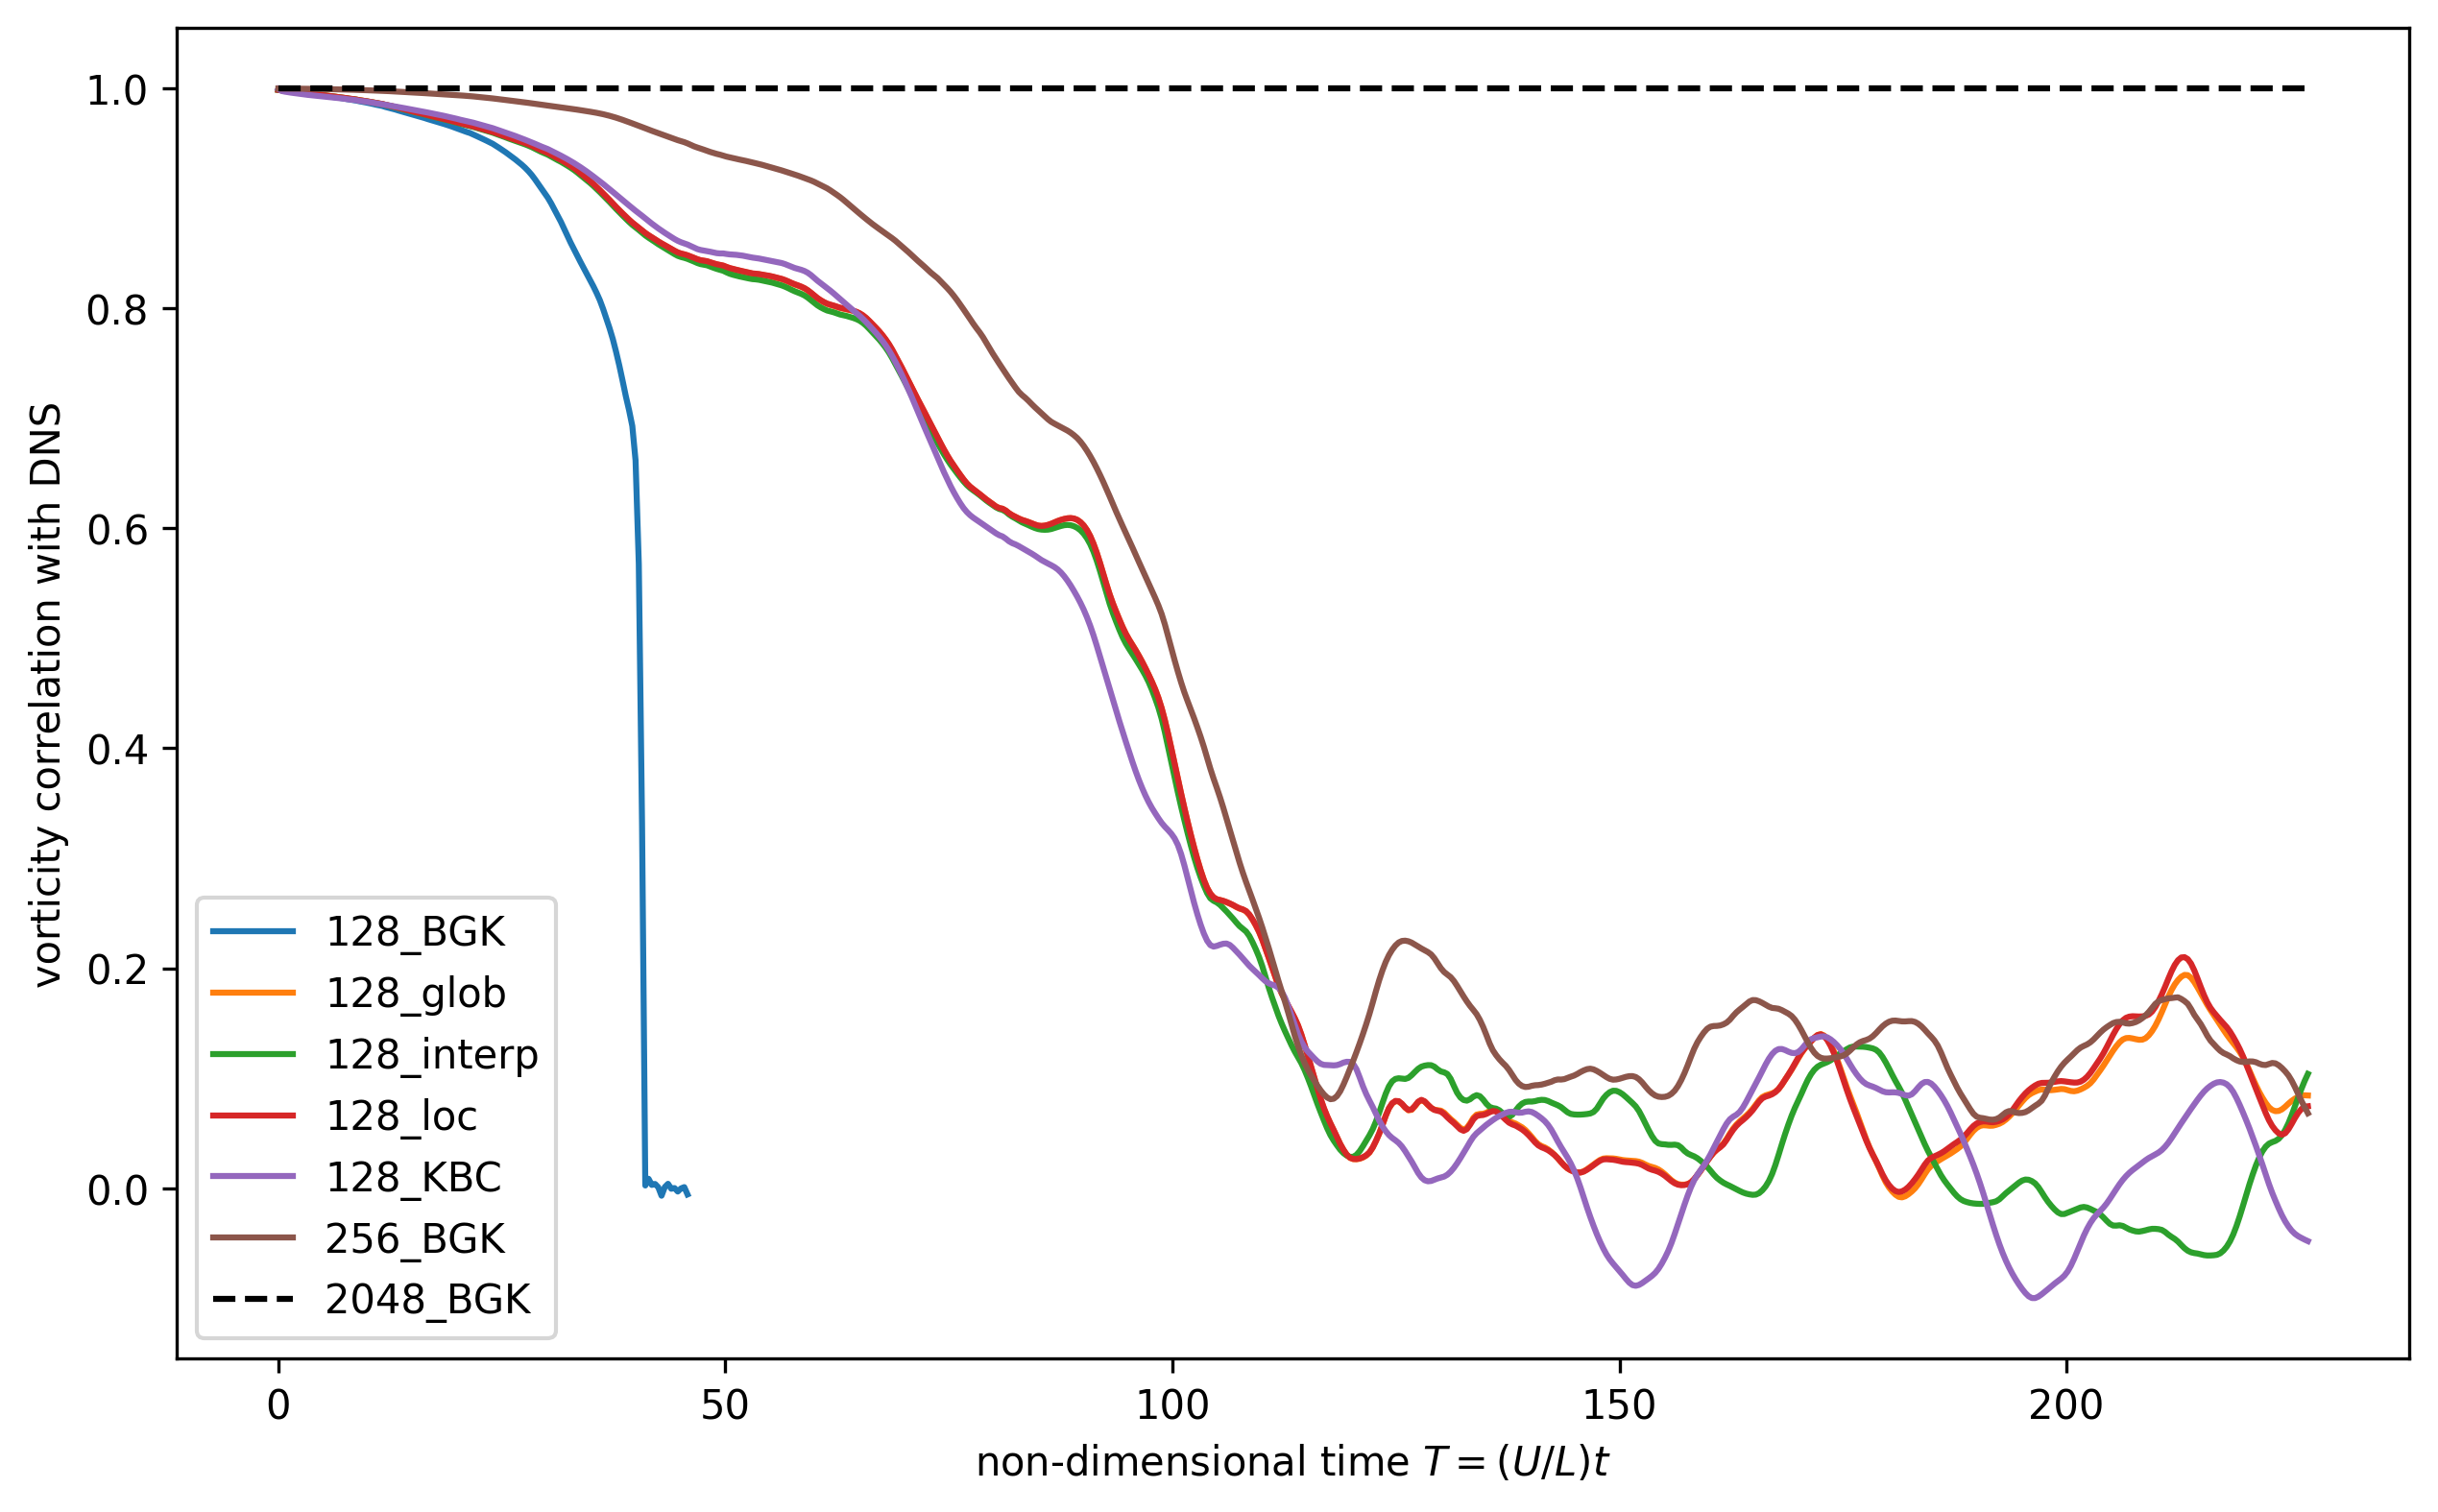

computing energy spectra:


100%|██████████| 312/312 [00:06<00:00, 49.63it/s]


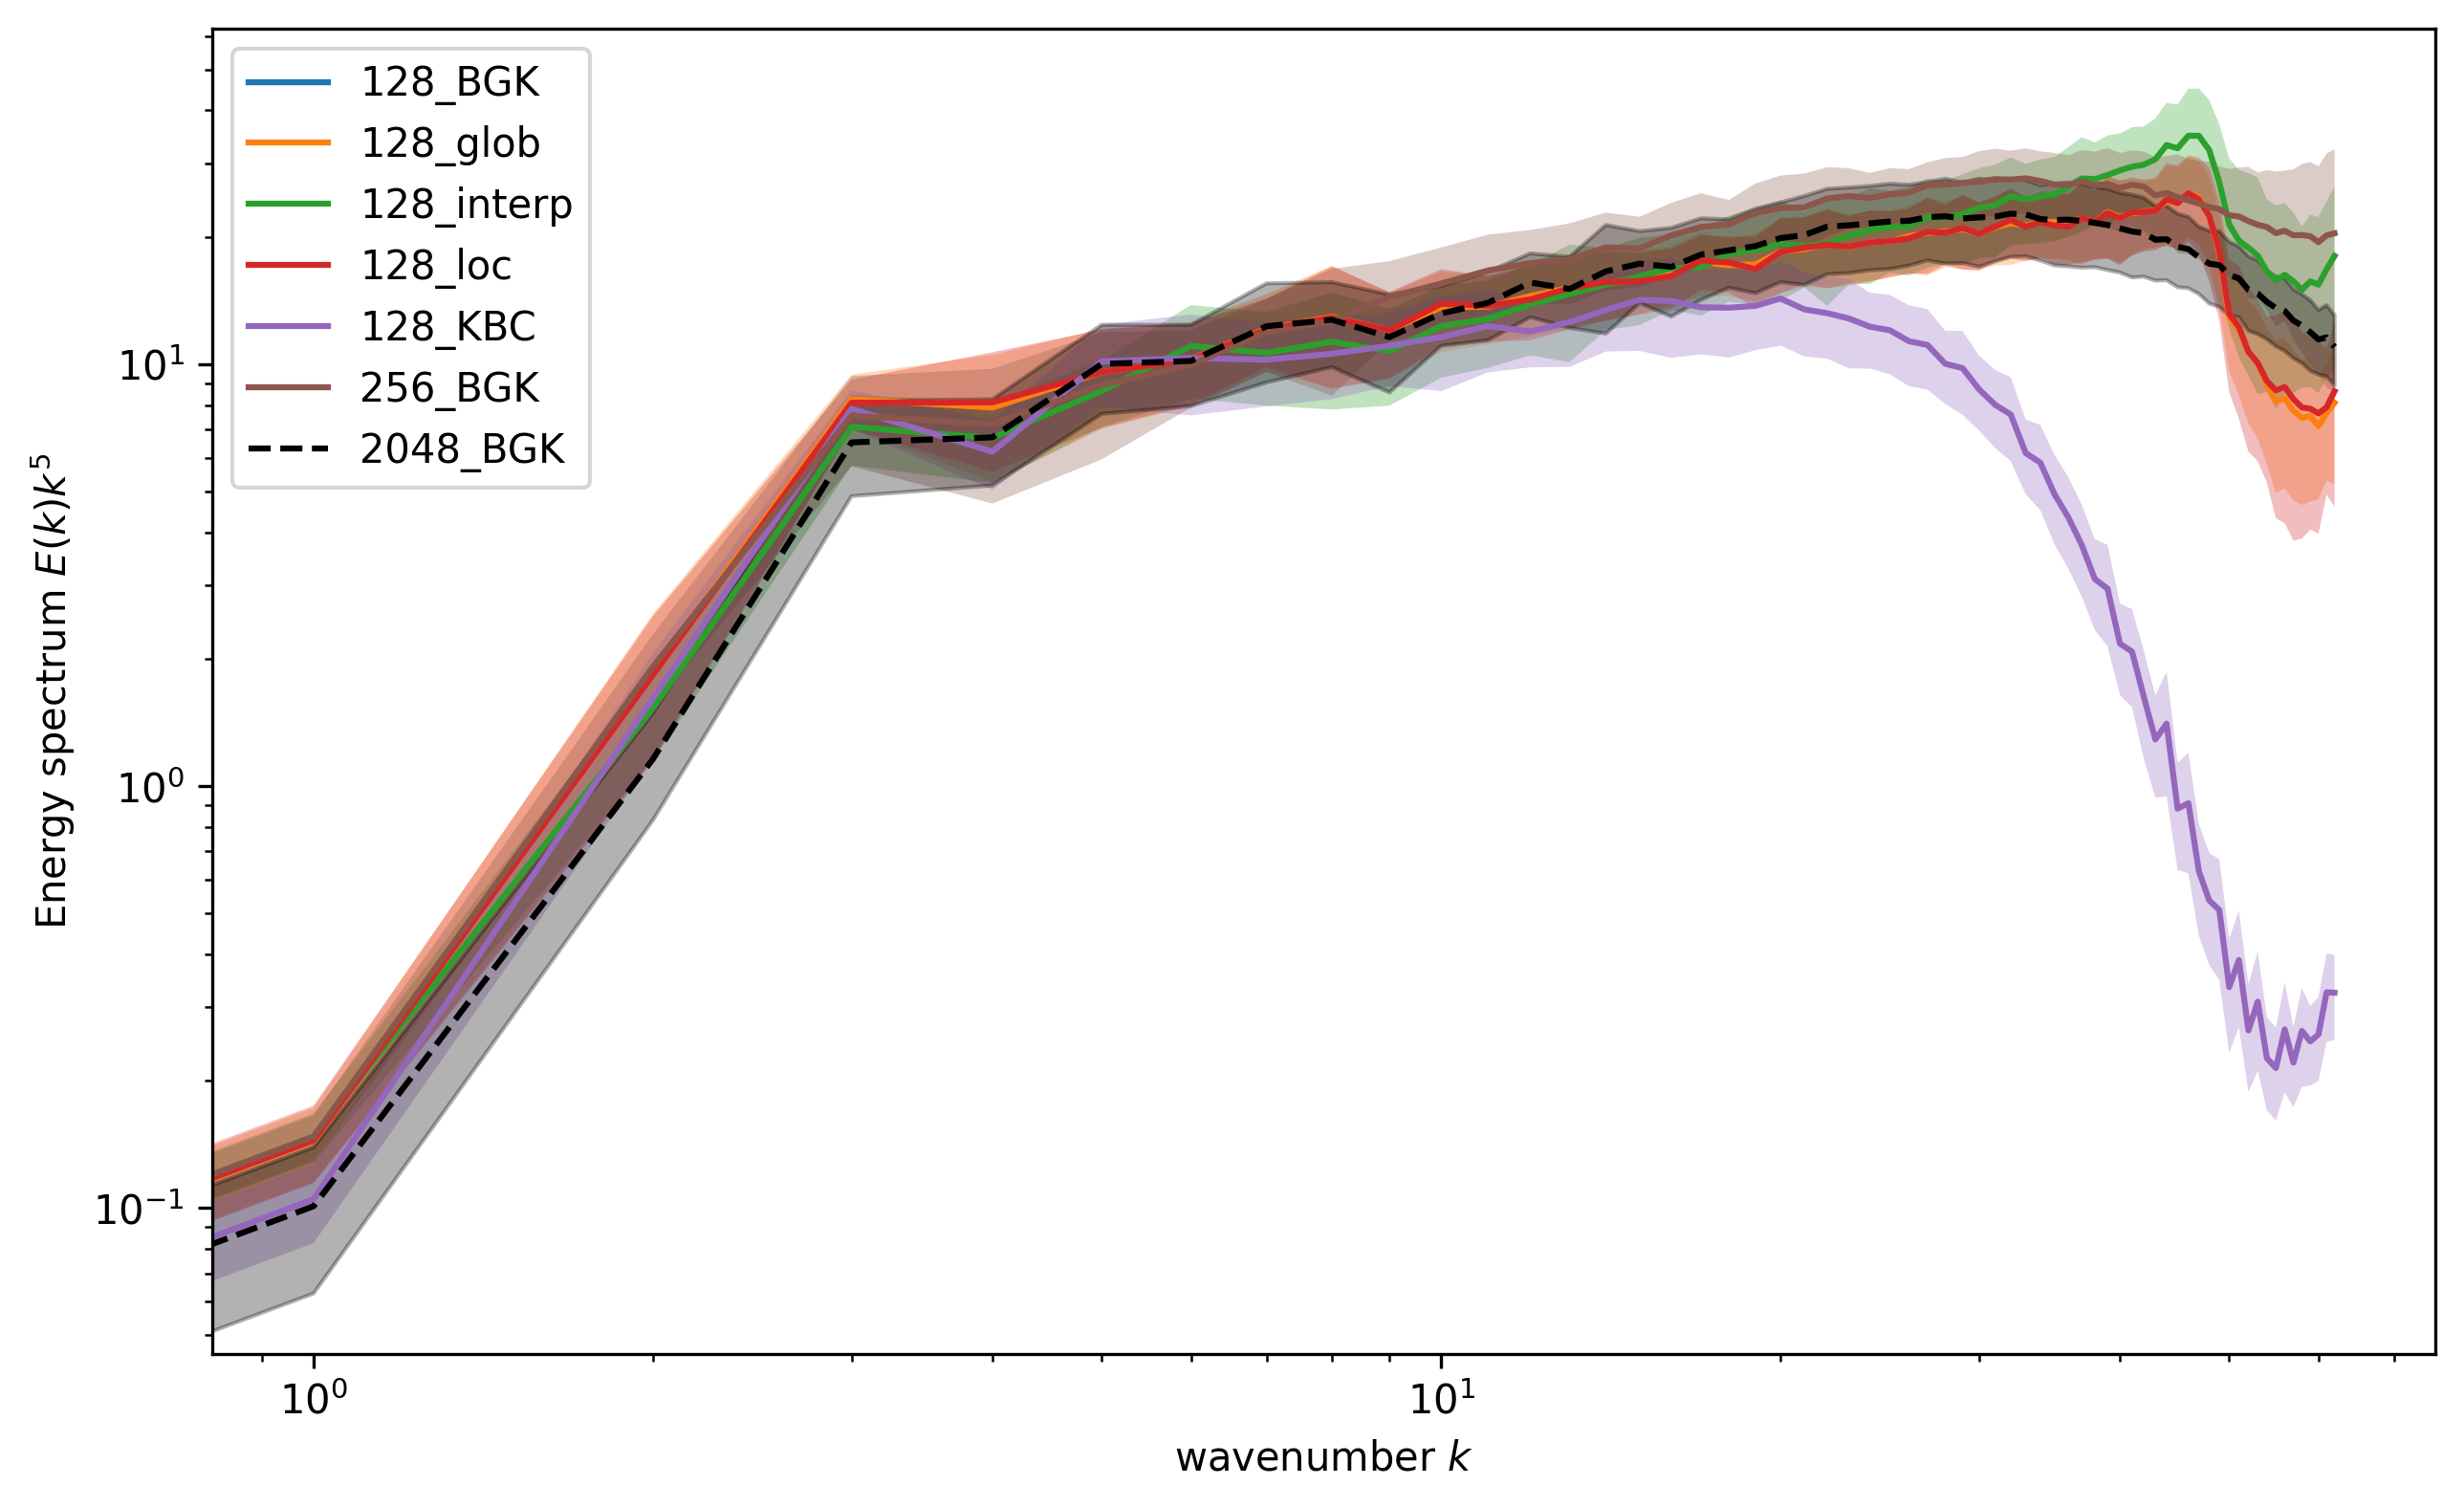

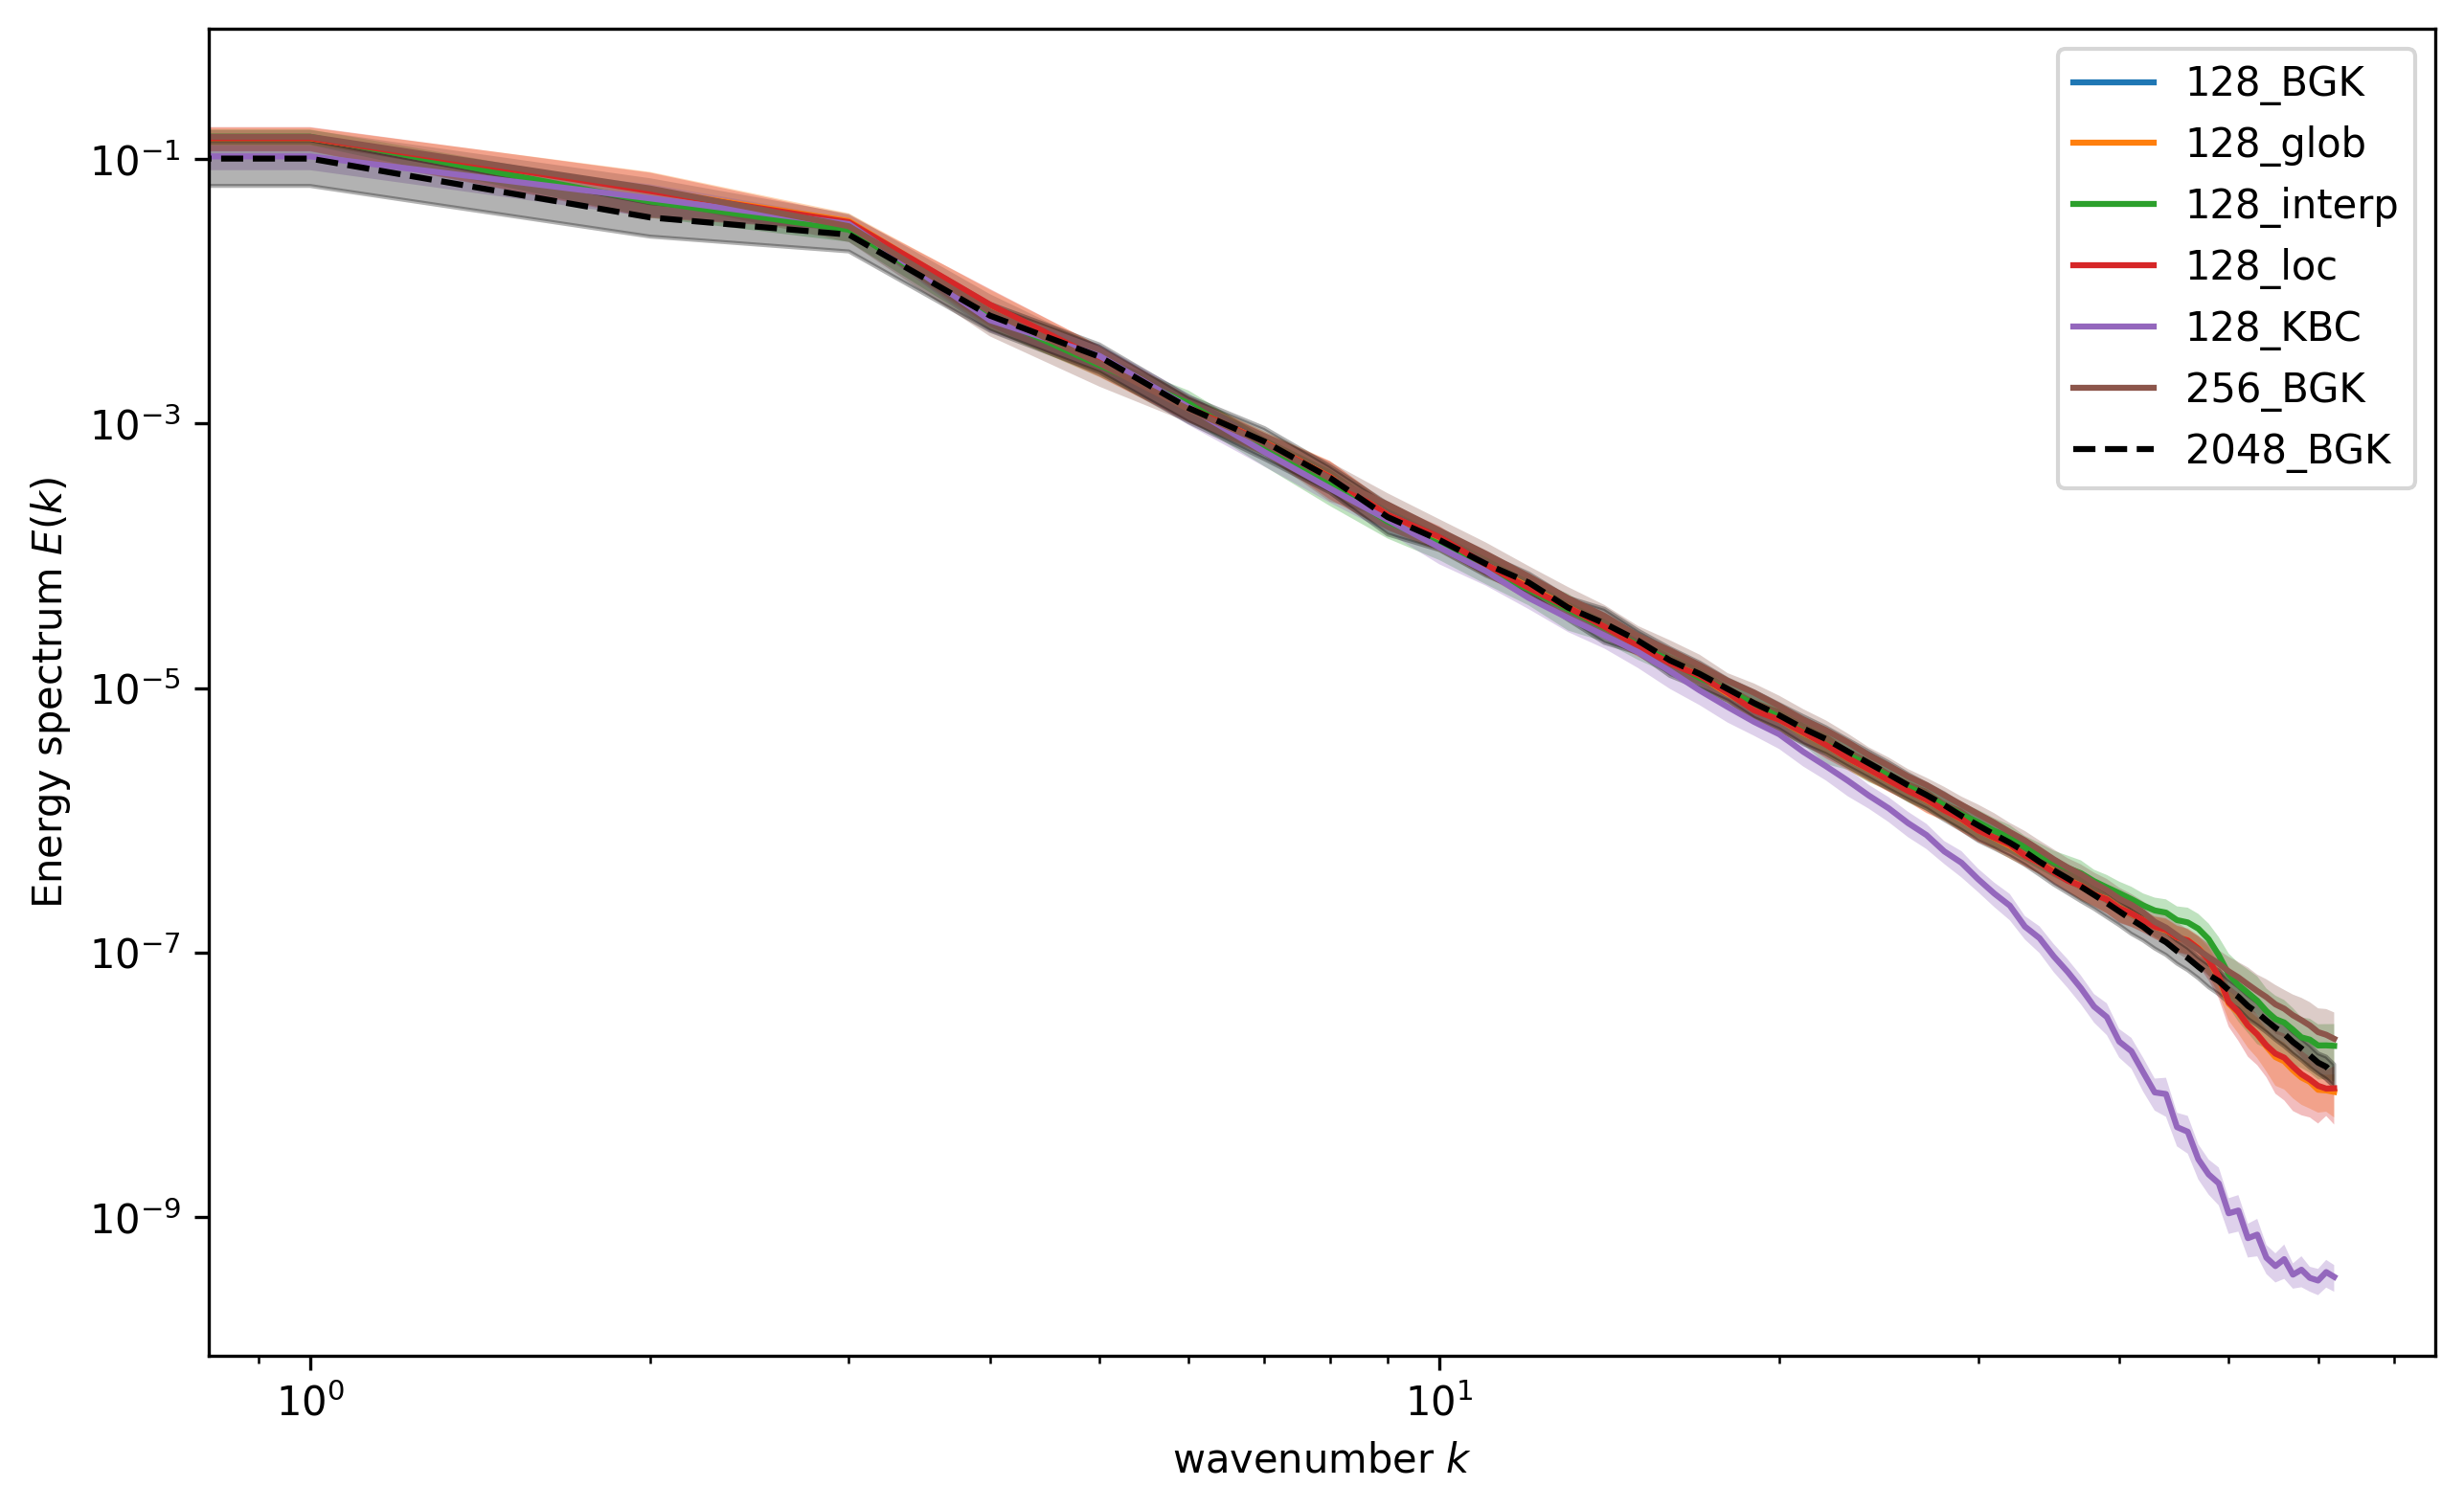

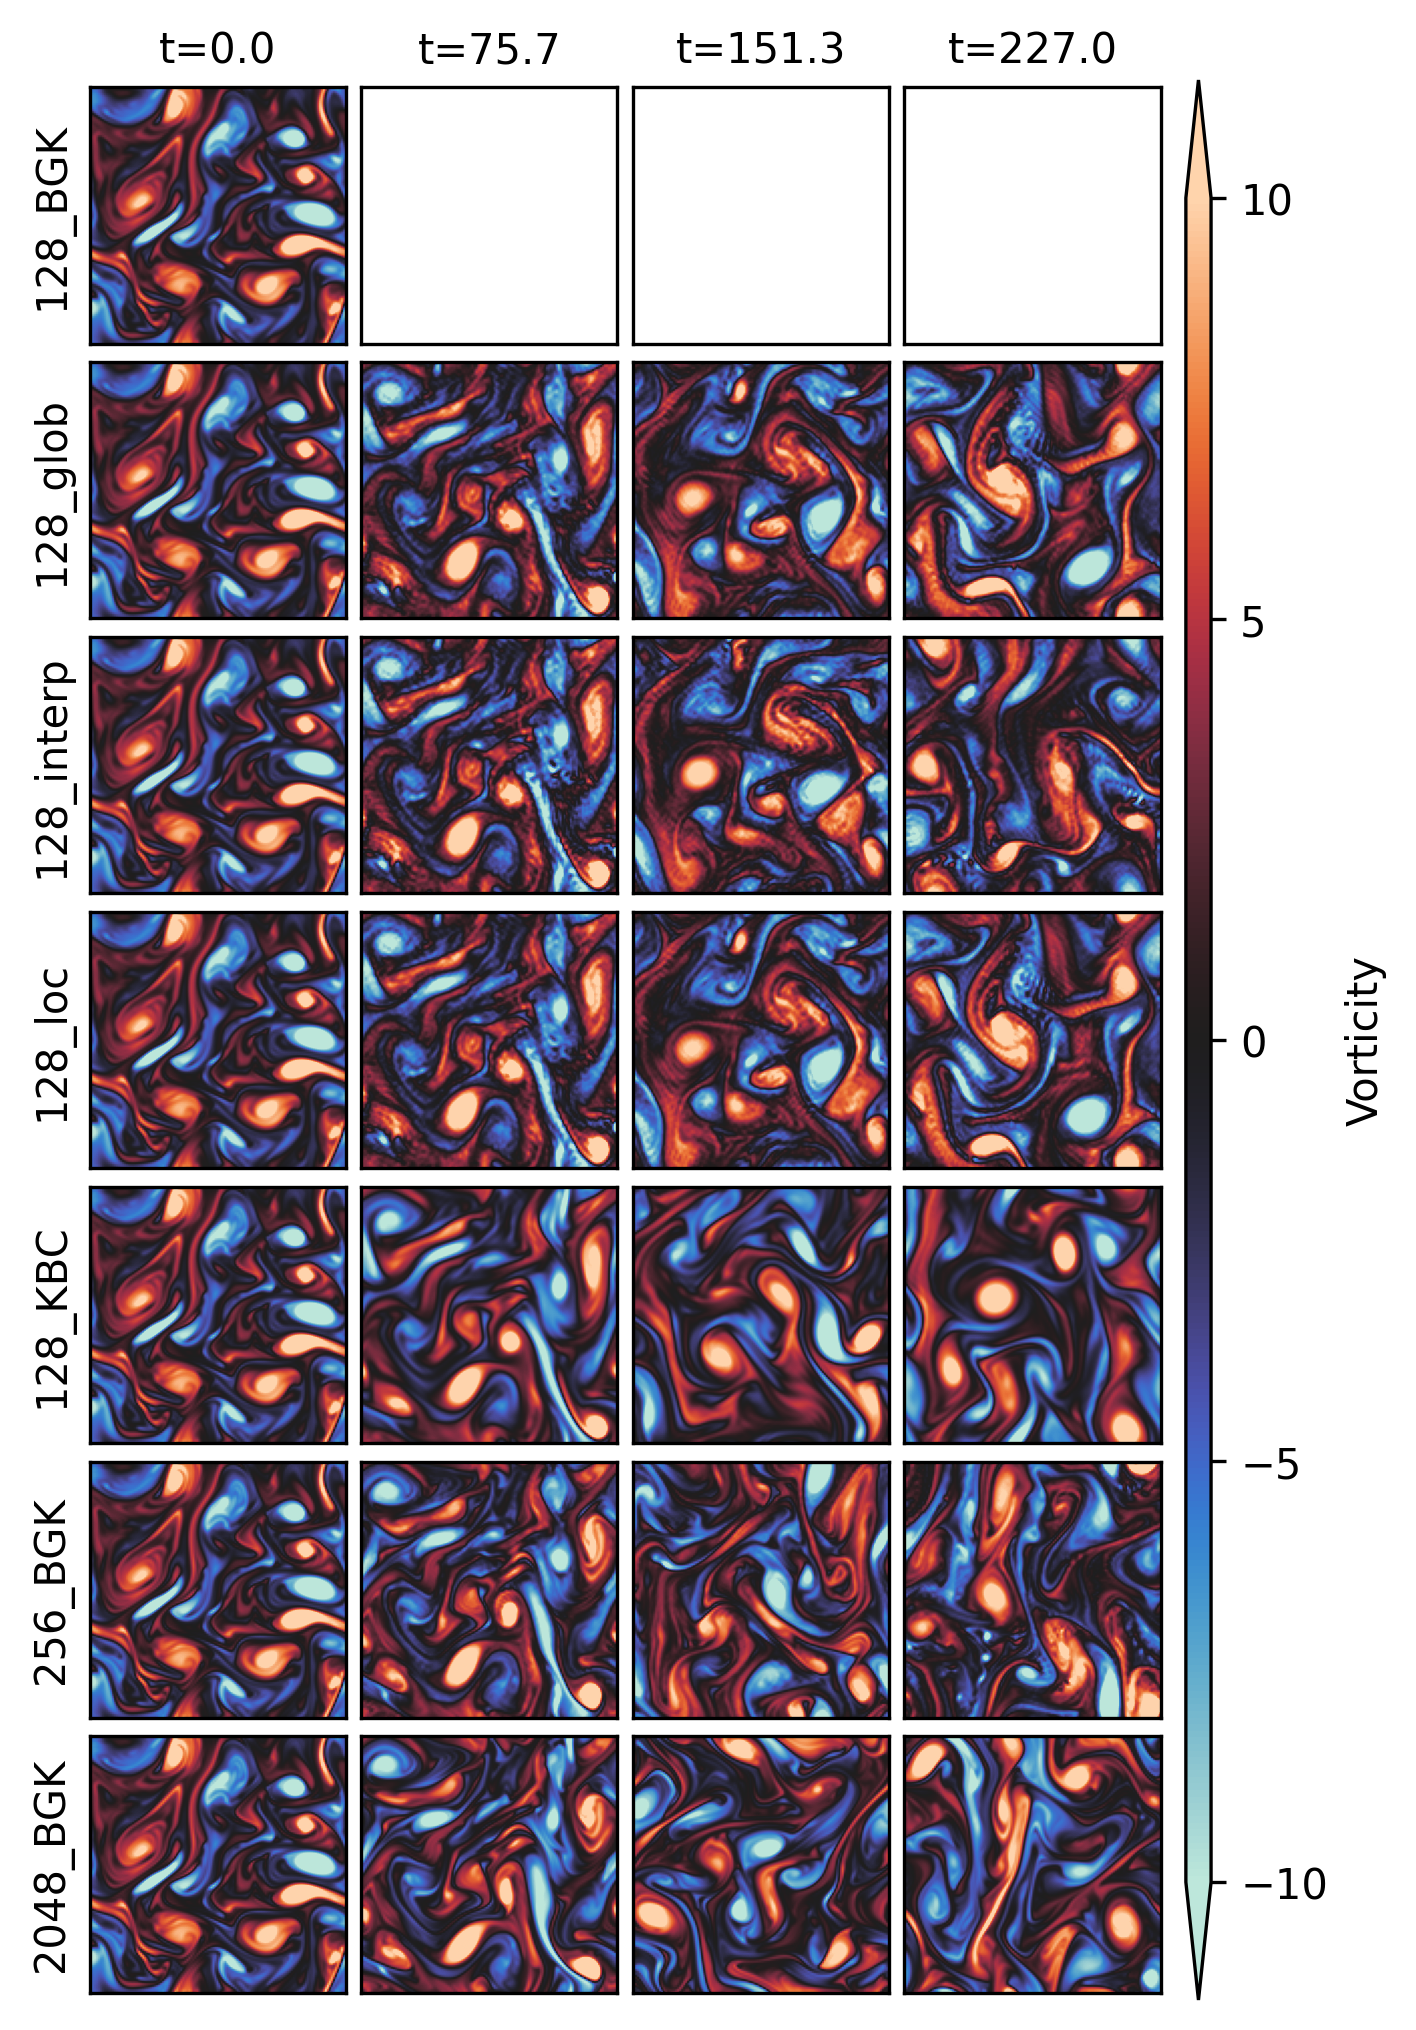

In [33]:
create_plots('re10000_T227_S33_Kolmogorov_runs/')

## Visualize models

In [17]:
from matplotlib import gridspec

# Create plots for gif of loc vs cgs vs dns
def plot_vorticity_and_spectra(v1, v2, v3, spec1, spec2, spec3, i):
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0.1)  # Reduced whitespace with wspace

    # Vorticity plots
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    im1 = ax1.imshow(v1, vmin=-10, vmax=10, cmap=sns.cm.icefire)
    im2 = ax2.imshow(v2, vmin=-10, vmax=10, cmap=sns.cm.icefire)
    im3 = ax3.imshow(v3, vmin=-10, vmax=10, cmap=sns.cm.icefire)

        # Hide axis labels and ticks but keep the axes visible
    ax1.set_xticks([])  # Remove x-ticks
    ax1.set_yticks([])  # Remove y-ticks
    ax2.set_xticks([])  # Remove x-ticks
    ax2.set_yticks([])  # Remove y-ticks
    ax3.set_xticks([])  # Remove x-ticks
    ax3.set_yticks([])  # Remove y-ticks

    ax1.set_title("128_BGK", fontsize=12)
    ax2.set_title("128_ReLBM", fontsize=12)
    ax3.set_title("2048_BGK", fontsize=12)

    # Energy spectrum plot
    ax4 = fig.add_subplot(gs[3])
    ax4.set_box_aspect(1)  # Ensure square aspect ratio for energy spectrum plot

    ax4.loglog(spec1, label="128_BGK", color='#1f77b4')
    ax4.loglog(spec2, label="128_ReLBM", color='#d62728')
    ax4.loglog(spec3, label="2048_BGK", color="black", linestyle="--")

    ax4.legend(fontsize=12)
    ax4.set_title("Energy Spectrum", fontsize=12)
    ax4.set_xlabel("Wavenumber k", fontsize=12)
    ax4.set_ylabel("Energy E(k)", fontsize=12)

    # Move y-label to the right side
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position('right')
    ax4.tick_params(axis='both', which='major', labelsize=12)

    plt.tight_layout()
    plt.savefig(f"visuals/img{i}.png", dpi=100)
    plt.close()


In [21]:
cgs_path = "re10000_T227_S33_Kolmogorov_runs/re10000_T227_N128_S33_U1_BGK/"
loc_path = "re10000_T227_S33_Kolmogorov_runs/re10000_T227_N128_S33_U1_ClosureRL-loc/"
fgs_path = "re10000_T227_S33_Kolmogorov_runs/re10000_T227_N2048_S33_U1_BGK/"
#get velocitiy fields from folders
cgs_vel = get_names(cgs_path)
loc_vel = get_names(loc_path)
fgs_vel = get_names(fgs_path)

M = len(fgs_vel)-1

In [ ]:
# Main loop
for i in tqdm(range(M)):
    #if i % 100 == 0:
        u1 = np.load(os.path.join(cgs_path, cgs_vel[i]))
        v1 = vorticity_2d(u1, 2.0*np.pi/128)
        _, spec1 = energy_spectrum_2d(u1)

        u2 = np.load(os.path.join(loc_path, loc_vel[i]))
        v2 = vorticity_2d(u2, 2.0*np.pi/128)
        _, spec2 = energy_spectrum_2d(u2)

        u3 = np.load(os.path.join(fgs_path, fgs_vel[i]))
        v3 = vorticity_2d(u3, 2.0*np.pi/128)
        _, spec3 = energy_spectrum_2d(u3)

        plot_vorticity_and_spectra(v1, v2, v3, spec1, spec2, spec3, i)

  0%|          | 0/626 [00:00<?, ?it/s]/tmp/ipykernel_2905068/2973581764.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
100%|██████████| 626/626 [00:04<00:00, 146.65it/s]


In [34]:
spec = np.load("dns_spectra/dns_mean_scaled.npy")
std = np.load("dns_spectra/dns_std_scaled_prior.npy")
std2 = np.load("dns_spectra/dns_std_scaled_posterior.npy")
std = np.abs(std)

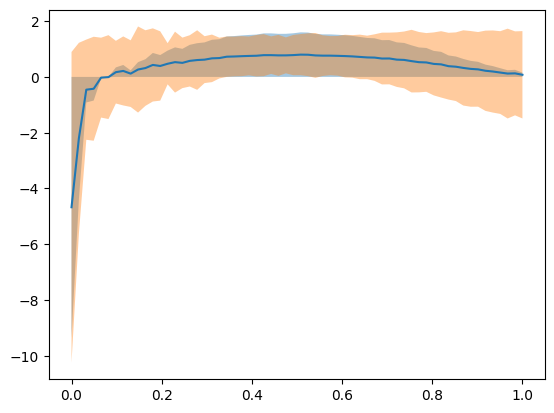

In [35]:
plt.figure()
k = np.linspace(0,1,spec.shape[0])
plt.plot(k, spec)
plt.fill_between(k, spec-std, spec+std, alpha=0.4)
plt.fill_between(k, spec-std2, spec+std2, alpha=0.4)

(62,)

In [23]:
std

array([-5.56632355, -3.41440278, -1.79620242, -1.86403901, -1.43196086,
       -1.50390352, -1.1237115 , -1.23728034, -1.19460138, -1.54361386,
       -1.35495897, -1.31170142, -1.24274444, -0.73762151, -1.09212916,
       -0.90525186, -0.91970575, -1.06778304, -0.839847  , -0.85255366,
       -0.7306091 , -0.7241931 , -0.71394227, -0.71834412, -0.69614846,
       -0.74371428, -0.75442164, -0.67362391, -0.73554149, -0.64442372,
       -0.72214788, -0.7379349 , -0.76853854, -0.8041624 , -0.72845808,
       -0.70150547, -0.71162404, -0.76422614, -0.76324162, -0.79862659,
       -0.77971411, -0.83457305, -0.92773974, -0.92682585, -0.97799789,
       -1.01847825, -1.1229692 , -1.0821897 , -1.05259554, -1.12866671,
       -1.18905127, -1.19689172, -1.23111054, -1.3489118 , -1.35768239,
       -1.33790875, -1.4386373 , -1.47217442, -1.48289625, -1.61000996,
       -1.5054247 , -1.56570484])